# import libraries

In [109]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
import re
import os
from keras.preprocessing.image import ImageDataGenerator
import cv2
from tqdm import tqdm
np.random.seed(42)
tf.random.set_seed(42)

 # pre-processing on labels csv file

In [ ]:
# read file
with open(f'Desktop\labels.csv','r') as file:
    content=file.read()
# replace all spacses with comma
content=re.sub(r'\s+',',',content)
# split each item have comma
data=content.split(",")
# make each item in column after 3 comma
data=[data[i:i+3] for i in range(0,len(data),3)]
# fill data
data="\n".join([",".join(x) for x in data])
# update file
with open(f'Desktop\labels.csv','w') as file:
    file.write(data) 

# Load data

In [110]:
data=pd.read_csv('Desktop\\labels.csv',header=None,names=['path','prob','labels'])
# make prob (0,0.33) equal 0 and (0.66,1) equal 1
data['prob']=data['prob'].replace([0,0.3333333333333333],0)
data['prob']=data['prob'].replace([1,0.6666666666666666],1)
# convert categorical data to numerical data
LE=LabelEncoder()
data['labels']=LE.fit_transform(data['labels'])

prob=data['prob']
labels=data['labels']

In [149]:
def load_img(image_dir):
    images = []
    for subdir, dirs, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                image_path = os.path.join(subdir, file)
                image=cv2.imread(image_path)
                image=cv2.resize(image,(227,227))
                img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                img = img.astype('uint8')
                clahe = cv2.createCLAHE(tileGridSize=(8,8))
                img = clahe.apply(img)
                img = np.expand_dims(img, 2)
                img = img.squeeze()
                images.append(img)
    
    images=(np.array(images, dtype = 'float32'))
    return images

# Loaded data

In [150]:
images_dir='D:\\AI Field\\Diploma AMIT\\Spacialization\\Projets\\datasets\\Solar\\solar images'

In [151]:
images=load_img(images_dir)

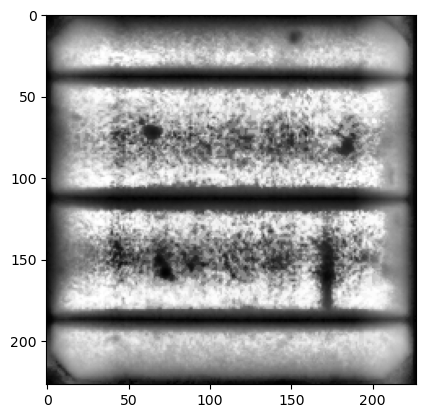

In [153]:
plt.imshow(images[8], cmap='gray')

# Pre-processing

In [154]:
# scale the data
images=images/255.0
images[0]

array([[0.00392157, 0.00392157, 0.00784314, ..., 0.02745098, 0.00392157,
        0.00392157],
       [0.00784314, 0.00784314, 0.01176471, ..., 0.02745098, 0.02745098,
        0.00392157],
       [0.01176471, 0.01176471, 0.03529412, ..., 0.04705882, 0.04705882,
        0.02745098],
       ...,
       [0.16470589, 0.03137255, 0.16470589, ..., 0.07058824, 0.07058824,
        0.01568628],
       [0.16470589, 0.16470589, 0.16470589, ..., 0.07058824, 0.04313726,
        0.01568628],
       [0.16470589, 0.16470589, 0.25490198, ..., 0.04313726, 0.04313726,
        0.01568628]], dtype=float32)

# Spliting to data

In [155]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train_images, X_test_images, X_train_probabilities, X_test_probabilities,y_train, y_test = train_test_split(images, prob, labels, test_size=0.2, random_state=42)


In [156]:
X_train_images.shape

(2099, 227, 227)

In [157]:
X_test_images.shape

(525, 227, 227)

In [158]:
X_train_probabilities.shape


(2099,)

In [159]:
y_train.shape

(2099,)

# Build Model without probability feature

In [166]:
model=keras.models.Sequential([
    # First layer AlexNet
    keras.layers.Conv2D(input_shape=[227,227,1],activation='selu',kernel_initializer='lecun_normal',
                        filters=96,kernel_size=5,strides=(4,4),padding='valid'),
    
    keras.layers.MaxPool2D(3,strides=(2,2),padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    # Second layer AlexNet
    keras.layers.Conv2D(activation='selu',kernel_initializer='lecun_normal',
                        filters=256,kernel_size=5,padding='same'),
    keras.layers.MaxPool2D(3,strides=(2,2),padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # Third layer AlexNet
    keras.layers.Conv2D(activation='selu',kernel_initializer='lecun_normal',
                        filters=256,kernel_size=5,padding='same'),
    keras.layers.MaxPool2D(3,strides=(2,2),padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    
    # Foruth layer AlexNet
    keras.layers.Conv2D(activation='selu',kernel_initializer='lecun_normal',
                        filters=256,kernel_size=2,padding='same'),
    keras.layers.MaxPool2D(2,strides=(2,2),padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # Conv Block layer AlexNet
    keras.layers.Conv2D(activation='selu',kernel_initializer='lecun_normal',
                        filters=384,kernel_size=3,padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(activation='selu',kernel_initializer='lecun_normal',
                        filters=384,kernel_size=3,padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(activation='selu',kernel_initializer='lecun_normal',
                        filters=256,kernel_size=3,padding='same'),
    keras.layers.BatchNormalization(),
    # Flatten layer 
    keras.layers.Flatten(),
    
    # Fully Connected Layer
    keras.layers.Dense(units=256,activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    # output layer
    keras.layers.Dense(units=1,activation='sigmoid'),
]
)

In [167]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 56, 56, 96)        2496      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_64 (Bat  (None, 27, 27, 96)       384       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 27, 27, 96)        0         
                                                                 
 conv2d_77 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 13, 13, 256)     

In [168]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [169]:
#lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
early_stopping= keras.callbacks.EarlyStopping(patience=2,verbose=1)

In [170]:
history=model.fit(X_train_images,
                  y_train, epochs=20, callbacks=[early_stopping],
                  validation_data=(X_test_images, y_test))


Epoch 1/20
66/66 [==============================] - 58s 807ms/step - loss: 0.2787 - accuracy: 0.9424 - val_loss: 2.4600 - val_accuracy: 0.6419
Epoch 2/20
66/66 [==============================] - 50s 761ms/step - loss: 0.0551 - accuracy: 0.9809 - val_loss: 2.9503 - val_accuracy: 0.5886
Epoch 3/20
66/66 [==============================] - 888s 14s/step - loss: 0.0475 - accuracy: 0.9843 - val_loss: 0.6152 - val_accuracy: 0.8076
Epoch 4/20
66/66 [==============================] - 51s 773ms/step - loss: 0.0334 - accuracy: 0.9881 - val_loss: 0.0199 - val_accuracy: 0.9924
Epoch 5/20
66/66 [==============================] - 54s 822ms/step - loss: 0.0422 - accuracy: 0.9848 - val_loss: 0.0124 - val_accuracy: 0.9962
Epoch 6/20
66/66 [==============================] - 50s 764ms/step - loss: 0.0326 - accuracy: 0.9924 - val_loss: 0.0164 - val_accuracy: 0.9962
Epoch 7/20
66/66 [==============================] - 53s 798ms/step - loss: 0.0149 - accuracy: 0.9933 - val_loss: 0.0093 - val_accuracy: 0.9962


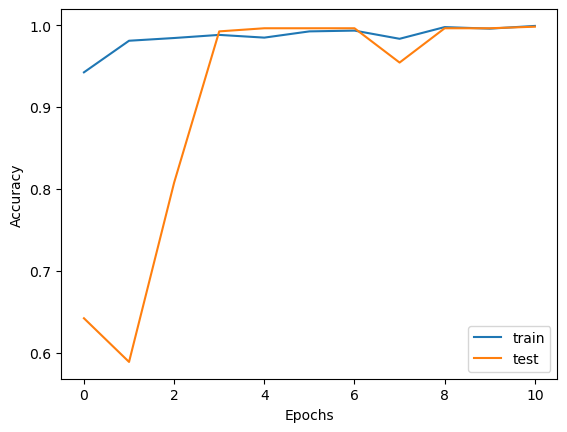

In [172]:
# plot accuracy to see the gap 
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

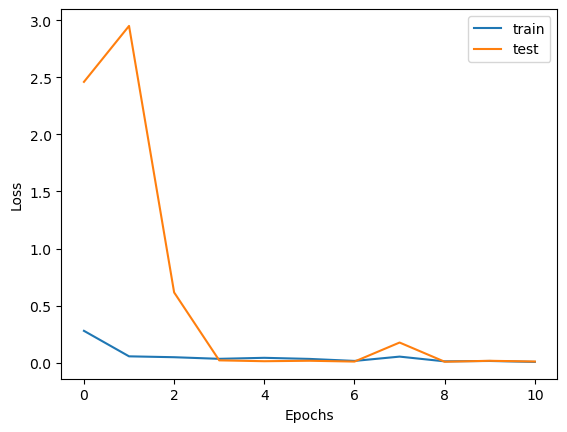

In [173]:
# plot accuracy to see the gap 
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [174]:
save_model=model.save('task_deep.h5')